LULC changes will be calculated 

In [1]:
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.geometry import Point, shape
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

Handelling Raster of 2023

In [2]:
# Path to your clipped raster file
raster_file = 'data/2023_lulc.tif'

# Open the raster and read data
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    
    # Get shapes with their values
    mask = raster_data > 0  # Create mask for non-zero values
    shapes = features.shapes(raster_data, mask=mask, transform=transform)
    
    # Convert shapes to GeoDataFrame
    geometries = []
    values = []
    
    for geom, val in shapes:
        geometries.append(shape(geom))
        values.append(val)
    
    # Create GeoDataFrame
    lulc23 = gpd.GeoDataFrame({
        'geometry': geometries,
        'value': values
    }, crs=src.crs)
    lulc23 = lulc23.to_crs(5243)

# Calculate area for each polygon
    lulc23['area'] = lulc23.geometry.area / 1_000_000 
    
    # Group by value and sum areas
    area_by_value = lulc23.groupby('value')['area'].sum().reset_index()
    print("Area by value:")
    print(area_by_value)

Area by value:
   value        area
0    1.0   48.185815
1    2.0  203.527022
2    4.0    0.091722
3    5.0   29.688104
4    7.0  586.794149
5    8.0    0.125090
6   11.0   21.488976


Handelling Raster of 2017

In [3]:
# Path to your clipped raster file
raster_file = 'data/2017_lulc.tif'

# Open the raster and read data
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    
    # Get shapes with their values
    mask = raster_data > 0  # Create mask for non-zero values
    shapes = features.shapes(raster_data, mask=mask, transform=transform)
    
    # Convert shapes to GeoDataFrame
    geometries = []
    values = []
    
    for geom, val in shapes:
        geometries.append(shape(geom))
        values.append(val)
    
    # Create GeoDataFrame
    lulc17 = gpd.GeoDataFrame({
        'geometry': geometries,
        'value': values
    }, crs=src.crs)
    lulc17 = lulc17.to_crs(5243)

# Calculate area for each polygon
    lulc17['area'] = lulc17.geometry.area / 1_000_000 
    
    # Group by value and sum areas
    area_by_value = lulc17.groupby('value')['area'].sum().reset_index()
    print("Area by value:")
    print(area_by_value)

Area by value:
   value        area
0    1.0   48.113267
1    2.0  205.367651
2    4.0    0.134789
3    5.0   33.429807
4    7.0  581.252061
5    8.0    0.041662
6   10.0    0.000699
7   11.0   21.560940


LULC class change analysis

In [4]:


# Assuming you have two GeoDataFrames for different years
# gdf_2017 - LULC for 2015
# gdf_2020 - LULC for 2020

# Calculate areas for each class in both years
def calculate_class_areas(gdf):
    return gdf.groupby('value')['area'].sum().round(2)

# Calculate areas
areas_2017 = calculate_class_areas(lulc17)
areas_2023 = calculate_class_areas(lulc23)

# Create a DataFrame with both years and calculate changes
change_df = pd.DataFrame({
    '2017': areas_2017,
    '2023': areas_2023
})

# Calculate absolute change
change_df['Area_Change'] = change_df['2023'] - change_df['2017']

# Calculate percentage change
change_df['Percent_Change'] = ((change_df['2023'] - change_df['2017']) / change_df['2017'] * 100).round(2)

# Rename index if needed
lulc_names = {
    1: 'Water',
    2: 'Trees',
    4: 'Flooded vegetation',
    5: 'Crops',
    7: 'Built Area',
    8: 'Bare ground',
    9: 'Snow/Ice',
    10: 'Clouds',
    11: 'Rangeland'
}
change_df.index = change_df.index.map(lulc_names)

# Sort by area change if desired
change_df = change_df.sort_values('Area_Change', ascending=False)

print("\nLULC Change Analysis (2015-2020)")
print("=================================")
print(change_df)
change_df = change_df.fillna(0)
print(change_df)
# Save to Excel with formatting
change_df.to_excel('lulc_change_analysis.xlsx')

# Optional: Print summary statistics
print("\nSummary Statistics:")
print(f"Total area changed: {abs(change_df['Area_Change']).sum():.2f} km²")
print(f"Largest increase: {change_df['Area_Change'].max():.2f} km² ({change_df['Area_Change'].idxmax()})")
print(f"Largest decrease: {change_df['Area_Change'].min():.2f} km² ({change_df['Area_Change'].idxmin()})")


LULC Change Analysis (2015-2020)
                      2017    2023  Area_Change  Percent_Change
value                                                          
Built Area          581.25  586.79         5.54            0.95
Bare ground           0.04    0.13         0.09          225.00
Water                48.11   48.19         0.08            0.17
Flooded vegetation    0.13    0.09        -0.04          -30.77
Rangeland            21.56   21.49        -0.07           -0.32
Trees               205.37  203.53        -1.84           -0.90
Crops                33.43   29.69        -3.74          -11.19
Clouds                0.00     NaN          NaN             NaN
                      2017    2023  Area_Change  Percent_Change
value                                                          
Built Area          581.25  586.79         5.54            0.95
Bare ground           0.04    0.13         0.09          225.00
Water                48.11   48.19         0.08            0.17
Floode

In [5]:
change_df

,2017,2023,Area_Change,Percent_Change
value,,,,
Built Area,581.25,586.79,5.54,0.95
Bare ground,0.04,0.13,0.09,225.00
Water,48.11,48.19,0.08,0.17
Flooded vegetation,0.13,0.09,-0.04,-30.77
Rangeland,21.56,21.49,-0.07,-0.32
Trees,205.37,203.53,-1.84,-0.90
Crops,33.43,29.69,-3.74,-11.19
Clouds,0.00,0.00,0.00,0.00


Using Seaborn for Plots

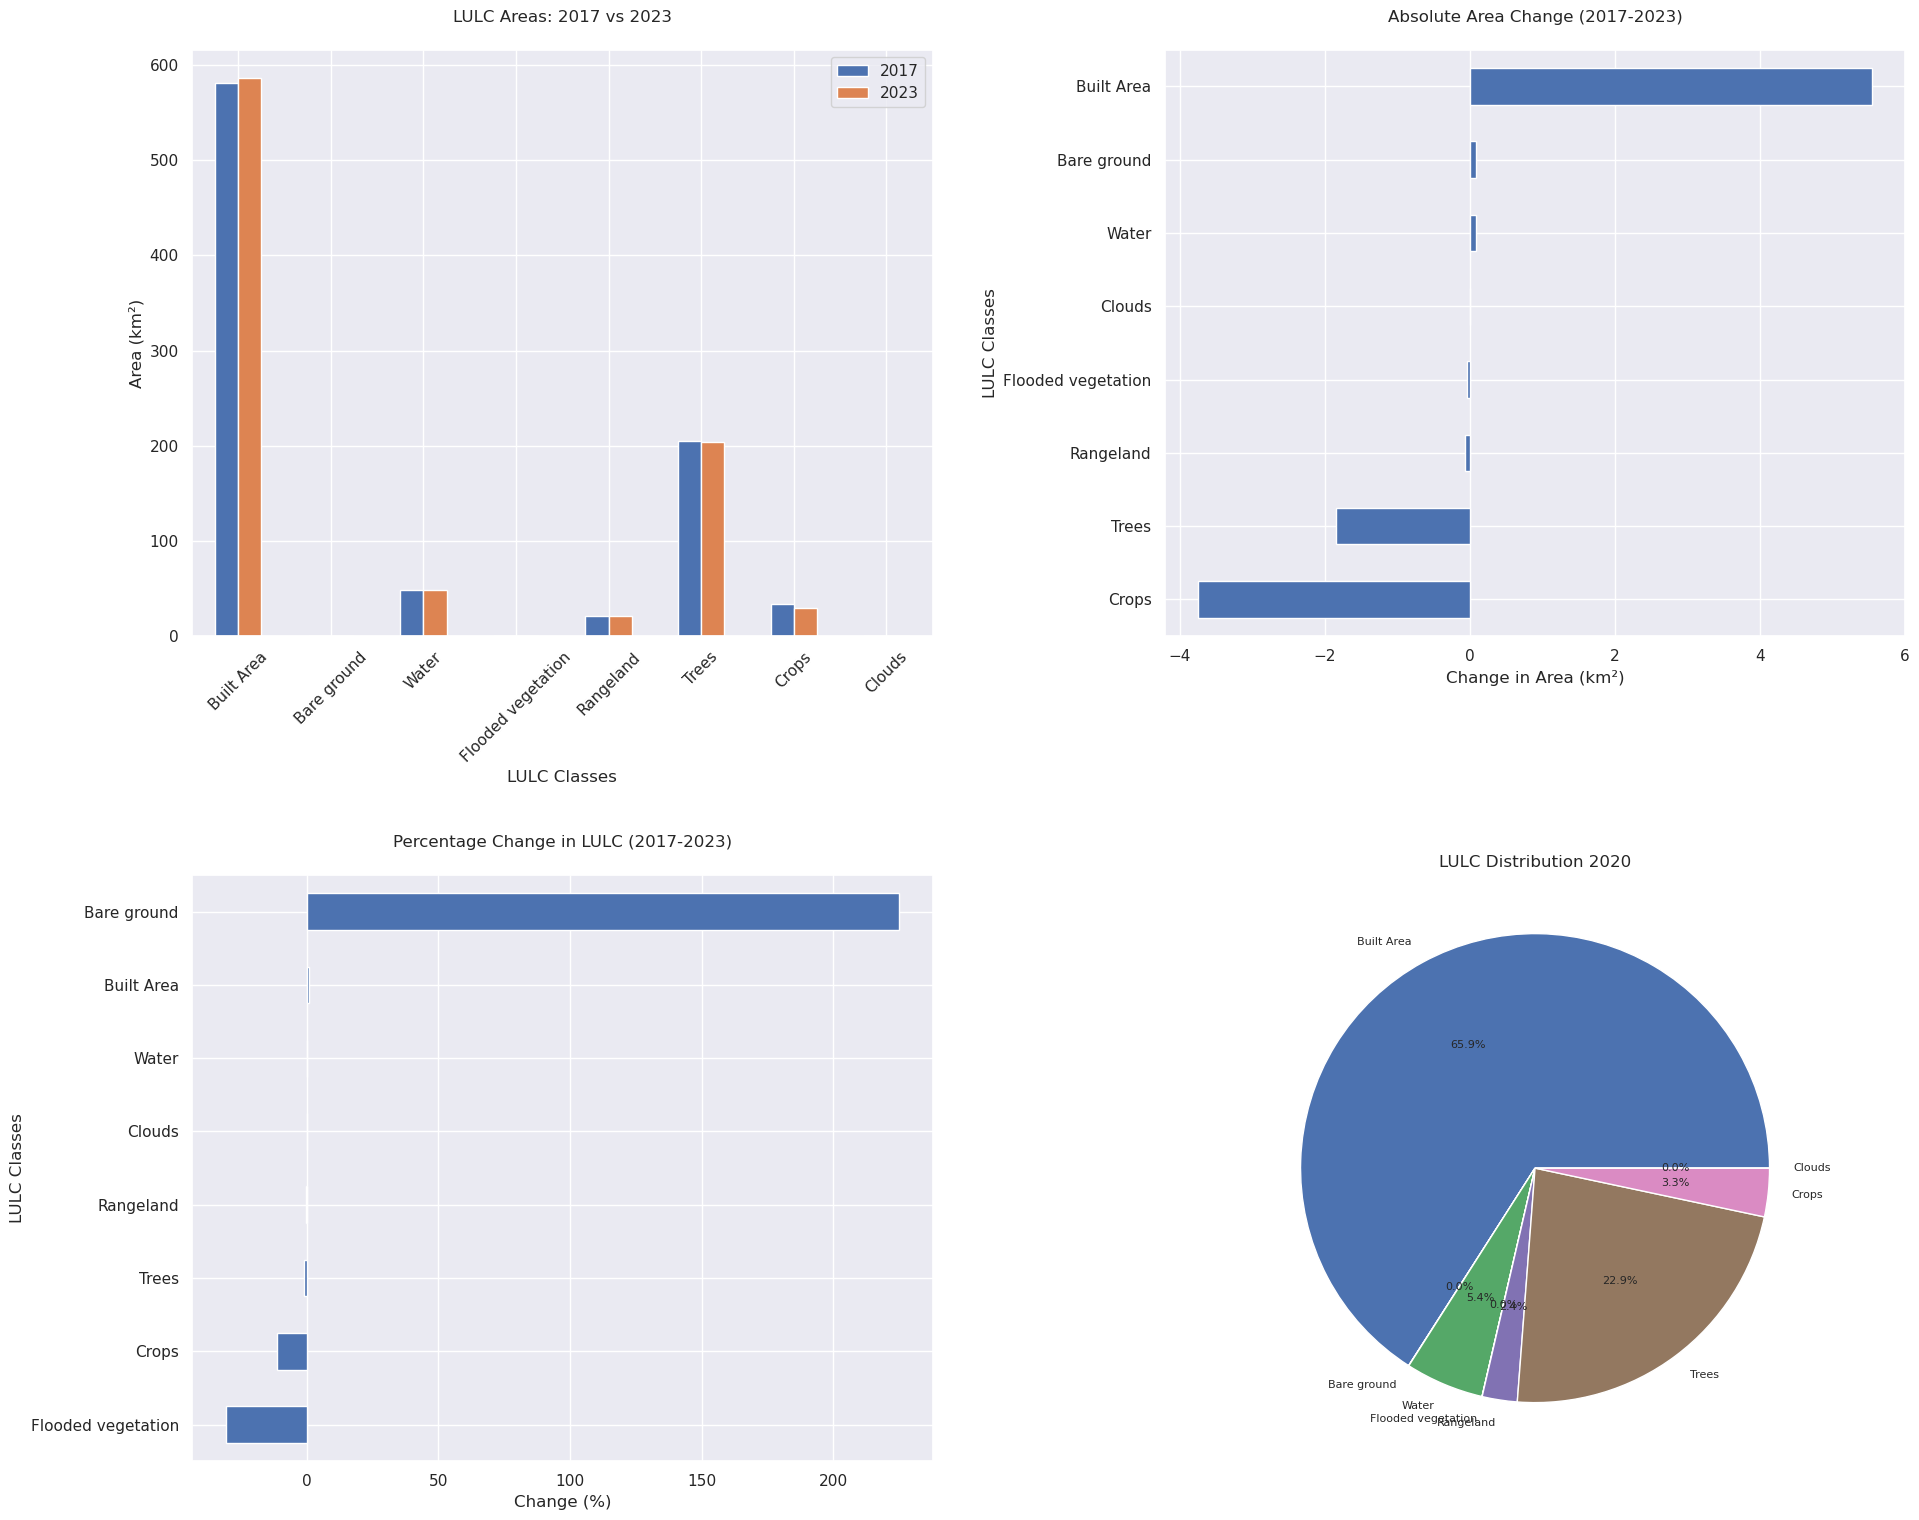

<Figure size 1200x600 with 0 Axes>

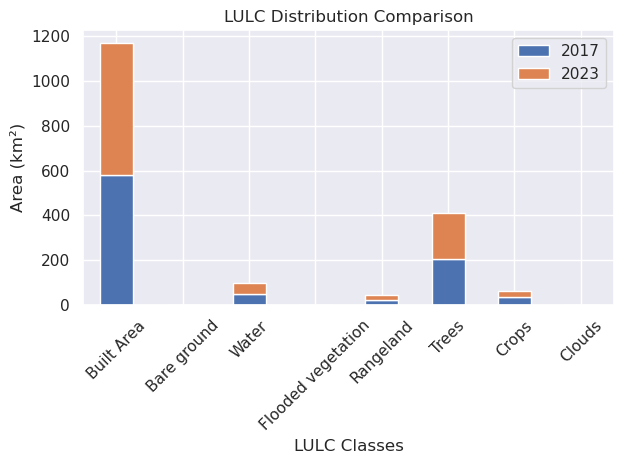

In [6]:
# Set style
plt.style.use('default')  # using default style instead of seaborn
sns.set_theme()  # This applies seaborn styling
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
# 1. Bar plot comparing areas in both years
change_df[['2017', '2023']].plot(kind='bar', ax=ax1)
ax1.set_title('LULC Areas: 2017 vs 2023', fontsize=12, pad=20)
ax1.set_xlabel('LULC Classes')
ax1.set_ylabel('Area (km²)')
ax1.tick_params(axis='x', rotation=45)

# 2. Area Change Plot (Horizontal bars)
change_df['Area_Change'].sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Absolute Area Change (2017-2023)', fontsize=12, pad=20)
ax2.set_xlabel('Change in Area (km²)')
ax2.set_ylabel('LULC Classes')

# 3. Percentage Change Plot
change_df['Percent_Change'].sort_values().plot(kind='barh', ax=ax3)
ax3.set_title('Percentage Change in LULC (2017-2023)', fontsize=12, pad=20)
ax3.set_xlabel('Change (%)')
ax3.set_ylabel('LULC Classes')

# 4. Pie charts comparison
ax4.pie(change_df['2023'], 
        labels=change_df.index, 
        autopct='%1.1f%%',
        textprops={'fontsize': 8})  # Reduce font size if needed
ax4.set_title('LULC Distribution 2020')


# Adjust layout
plt.tight_layout(pad=3.0)

# Save plots
plt.savefig('output/lulc_change_analysis.png', dpi=300, bbox_inches='tight')
# plt.savefig('lulc_change_analysis.pdf', bbox_inches='tight')

# Optional: Create a separate stacked bar chart
plt.figure(figsize=(12, 6))
change_df[['2017', '2023']].plot(kind='bar', stacked=True)
plt.title('LULC Distribution Comparison')
plt.xlabel('LULC Classes')
plt.ylabel('Area (km²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('lulc_stacked_comparison.png', dpi=300, bbox_inches='tight')

# Show all plots
plt.show()


Code of saving plots 

In [7]:
# Set style
plt.style.use('default')
sns.set_theme()

# Bar plot comparing areas
plt.figure(figsize=(10, 8))
change_df[['2017', '2023']].plot(kind='bar')
plt.title('LULC Areas: 2017 vs 2023', fontsize=12, pad=20)
plt.xlabel('LULC Classes')
plt.ylabel('Area (km²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/lulc_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.close()

# Area Change Plot
plt.figure(figsize=(10, 8))
change_df['Area_Change'].sort_values().plot(kind='barh')
plt.title('Absolute Area Change (2017-2023)', fontsize=12, pad=20)
plt.xlabel('Change in Area (km²)')
plt.ylabel('LULC Classes')
plt.tight_layout()
plt.savefig('output/lulc_area_change.png', dpi=300, bbox_inches='tight')
plt.close()

# Percentage Change Plot
plt.figure(figsize=(10, 8))
change_df['Percent_Change'].sort_values().plot(kind='barh')
plt.title('Percentage Change in LULC (2017-2023)', fontsize=12, pad=20)
plt.xlabel('Change (%)')
plt.ylabel('LULC Classes')
plt.tight_layout()
plt.savefig('output/lulc_percent_change.png', dpi=300, bbox_inches='tight')
plt.close()

# Pie charts comparison
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.pie(change_df['2017'], labels=change_df.index, autopct='%1.1f%%')
# plt.title('LULC Distribution 2017')
# plt.subplot(122)
# plt.pie(change_df['2023'], labels=change_df.index, autopct='%1.1f%%')
# plt.title('LULC Distribution 2023')
# plt.tight_layout()
# plt.savefig('output/lulc_pie_charts.png', dpi=300, bbox_inches='tight')
# plt.close()

# Stacked bar chart
plt.figure(figsize=(12, 6))
change_df[['2017', '2023']].plot(kind='bar', stacked=True)
plt.title('LULC Distribution Comparison')
plt.xlabel('LULC Classes')
plt.ylabel('Area (km²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/lulc_stacked_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

<Figure size 1000x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Creating Map of LULC

In [8]:
def create_lulc_map(raster_file, lulc_names, output_path, sample_step=10, figsize=(14, 8), 
                    cmap='RdBu', markersize=1, alpha=0.7, title='LULC Map', dpi=300):
    """
    Create a Land Use Land Cover (LULC) map from a raster file using GeoPandas.
    
    Parameters:
    -----------
    raster_file : str
        Path to the input raster file
    lulc_names : dict
        Dictionary mapping class values to their names
    output_path : str
        Path where the output figure should be saved
    sample_step : int
        Step size for sampling points from the raster (default: 10)
    figsize : tuple
        Figure size in inches (default: (14, 8))
    cmap : str
        Colormap to use for the visualization (default: 'RdBu')
    markersize : float
        Size of the markers in the plot (default: 1)
    alpha : float
        Transparency of the markers (default: 0.7)
    title : str
        Title for the map (default: 'LULC Map')
    dpi : int
        Resolution of the output figure (default: 300)
    """
    try:
        # Read the raster data
        with rasterio.open(raster_file) as src:
            raster_data = src.read(1)
            transform = src.transform
            crs = src.crs
            rows, cols = raster_data.shape

        # Create points and values lists
        points = []
        values = []
        
        # Sample points from the raster
        for row in range(0, rows, sample_step):
            for col in range(0, cols, sample_step):
                value = raster_data[row, col]
                if value > 0:  # Only include non-zero values
                    x, y = rasterio.transform.xy(transform, row, col)
                    points.append(Point(x, y))
                    values.append(value)

        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({
            'class': values,
            'class_name': [lulc_names.get(v, 'Unknown') for v in values],
            'geometry': points
        }, crs=crs)

        # Create the visualization
        fig, ax = plt.subplots(figsize=figsize)
        
     # Get Tab10 colors
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        
        # Plot each class separately
        unique_classes = sorted(lulc_names.keys())
        for idx, class_value in enumerate(unique_classes):
            mask = gdf['class'] == class_value
            if mask.any():
                color_idx = idx % 10  # Ensure we don't exceed the tab10 color range
                gdf[mask].plot(
                    ax=ax,
                    color=colors[color_idx],
                    markersize=markersize,
                    alpha=alpha,
                    label=lulc_names[class_value]
                )

        # Add legend
        ax.legend(
            title='Land Use Classes',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            fontsize='small',
            title_fontsize='medium'
        )
        
        # Style the plot
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
        ax.set_title(title, fontsize=24, color='darkcyan', pad=20)
        
        # Add grid and adjust layout
        ax.grid(True, color='gray', linestyle='--', alpha=0.3)
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
        plt.close()
        
        return gdf
        
    except Exception as e:
        print(f"Error creating LULC map: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    lulc_names = {
        1: 'Water',
        2: 'Trees',
        4: 'Flooded vegetation',
        5: 'Crops',
        7: 'Built Area',
        8: 'Bare ground',
        9: 'Snow/Ice',
        10: 'Clouds',
        11: 'Rangeland'
    }
    
    gdf = create_lulc_map(
        raster_file='data/2017_lulc.tif',
        lulc_names=lulc_names,
        output_path='output/lulc_map_2017.png',
        title='LULC of Berlin 2017'
    )
    
    if gdf is not None:
        print("Map created successfully!")
        print("\nFirst few rows of the GeoDataFrame:")
        print(gdf.head())

Map created successfully!

First few rows of the GeoDataFrame:
   class class_name                        geometry
0      2      Trees  POINT (396915.000 5837145.000)
1      5      Crops  POINT (397115.000 5837145.000)
2      2      Trees  POINT (396815.000 5837045.000)
3      2      Trees  POINT (396915.000 5837045.000)
4      2      Trees  POINT (397015.000 5837045.000)
